In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
frac = 0.01

In [65]:
dtypes = {'fare_amount': 'float32', 
          'pickup_longitude': 'float32', 
          'pickup_latitude': 'float32', 
          'dropoff_longitude': 'float32'}

df_train = pd.read_csv('./train.csv/train.csv', 
                       header=0, 
                       dtype = dtypes, 
                       parse_dates= ['pickup_datetime'], 
                       skiprows= lambda i: i>0 and random.random()>frac)

In [66]:
# Cheking for rows with null values
df_train.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    6
dropoff_latitude     6
passenger_count      0
dtype: int64

In [67]:
# Since there are only 10 rows in the sampled 500000 which is ~0.002% simply dropping them will not have too much of an effect on the prediction
df_train.dropna(inplace=True, axis=0)
df_train.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [68]:
# Converting the datetime column from string to datetime and extracting various features from it. 
df_train['pickup_datetime'] = pd.to_datetime(df_train.pickup_datetime)
df_train.loc[:, 'pickup_hour'] = df_train['pickup_datetime'].dt.hour
df_train.loc[:, 'pickup_weekday'] = df_train['pickup_datetime'].dt.day_name()
df_train.loc[:, 'pickup_date'] = df_train['pickup_datetime'].dt.day
df_train.loc[:, 'pickup_month'] = df_train['pickup_datetime'].dt.month
df_train.loc[:, 'pickup_day'] = df_train['pickup_datetime'].dt.dayofweek

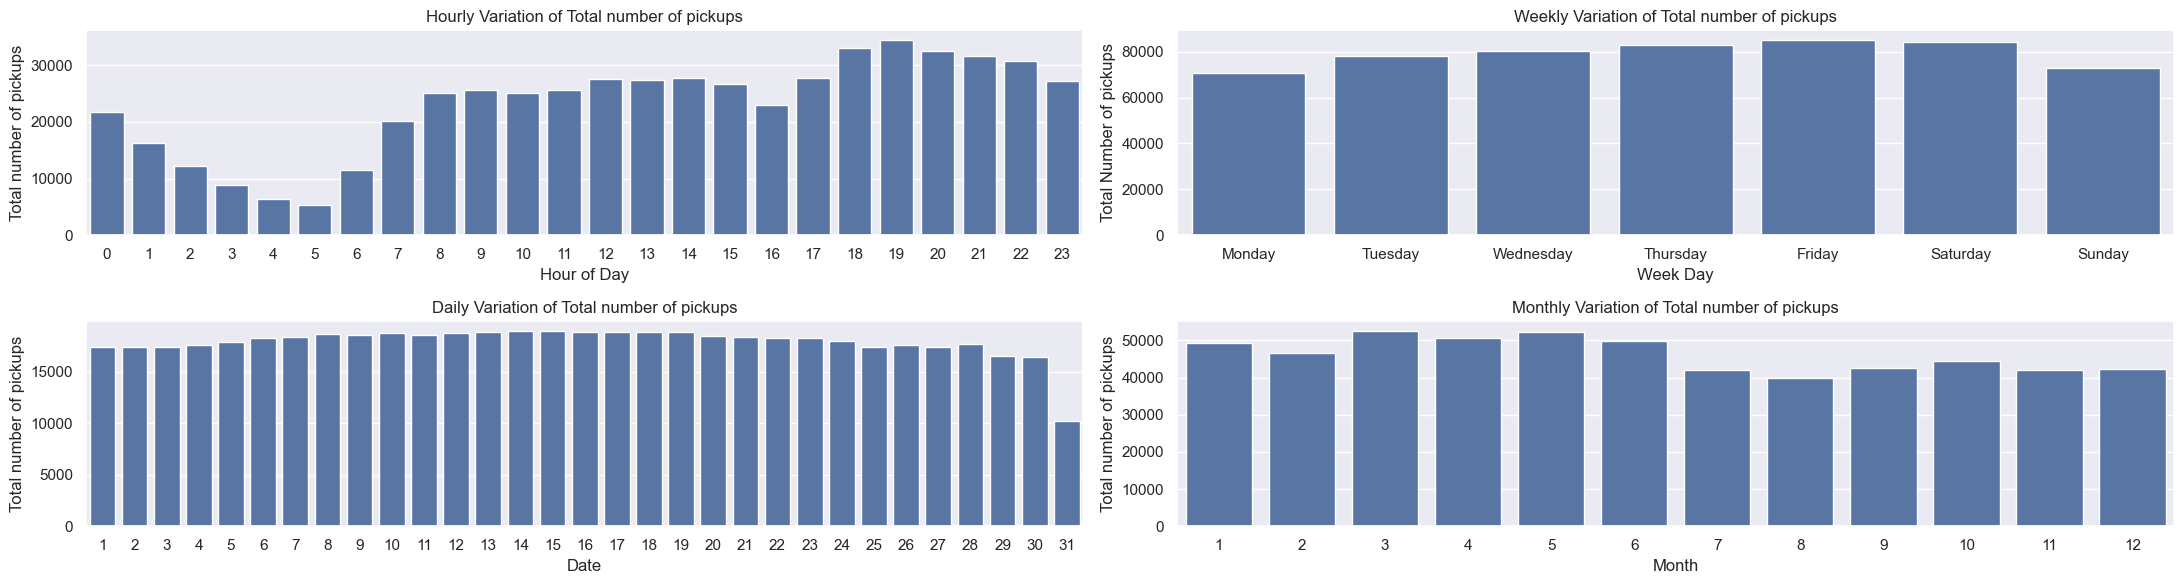

In [69]:
# Ensure that the 'pickup_weekday' column is of type 'category'
df_train['pickup_weekday'] = pd.Categorical(df_train['pickup_weekday'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)

plt.figure(figsize=(22, 6))

# Hour of day
plt.subplot(221)
sns.countplot(x='pickup_hour', data=df_train)
plt.xlabel('Hour of Day')
plt.ylabel('Total number of pickups')
plt.title('Hourly Variation of Total number of pickups')

# Date
plt.subplot(223)
sns.countplot(x='pickup_date', data=df_train)
plt.xlabel('Date')
plt.ylabel('Total number of pickups')
plt.title('Daily Variation of Total number of pickups')

# Day of week
plt.subplot(222)
sns.countplot(x='pickup_weekday', data=df_train, order=['Monday', 'Tuesday', 'Wednesday', 
                                                        'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xlabel('Week Day')
plt.ylabel('Total Number of pickups')
plt.title('Weekly Variation of Total number of pickups')

# Month
plt.subplot(224)
sns.countplot(x='pickup_month', data=df_train)
plt.xlabel('Month')
plt.ylabel('Total number of pickups')
plt.title('Monthly Variation of Total number of pickups')

plt.tight_layout()
plt.show()

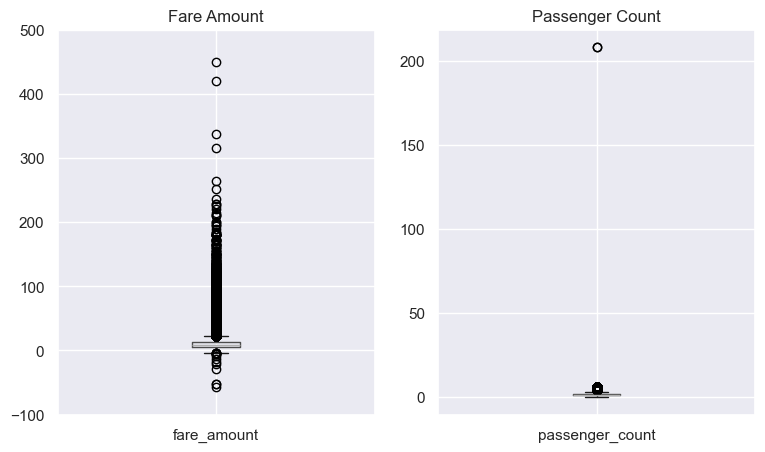

In [70]:
fig, ax = plt.subplots(1,2)

df_train.boxplot(column='fare_amount', ax=ax[0])
ax[0].set_title('Fare Amount')
ax[0].set_ylim(-100, 500)

df_train.boxplot(column='passenger_count', ax=ax[1])
ax[1].set_title('Passenger Count')

plt.show()

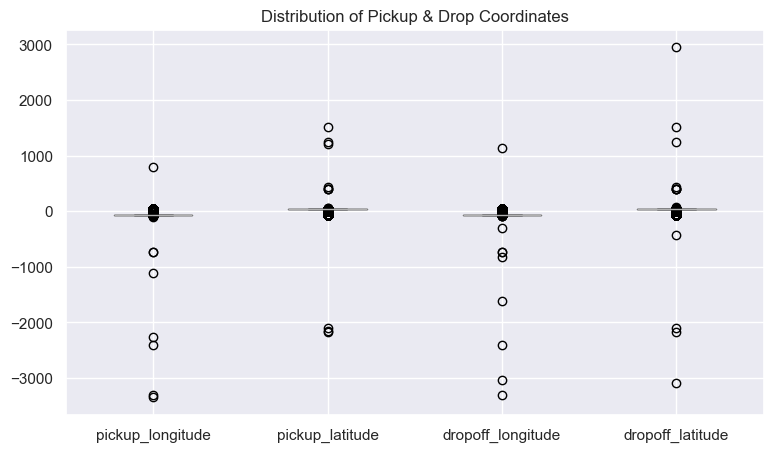

In [71]:
plt.rcParams['figure.figsize'] = (9,5)

ax= df_train[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']].boxplot()
ax.set_title('Distribution of Pickup & Drop Coordinates')

plt.show()

In [72]:
# List of columns to remove outliers from
columns_to_clean = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'fare_amount', 'passenger_count']

# Function to remove outliers using Z-score method
def remove_outliers_zscore(df, columns, threshold=3):
    df_clean = df.copy()
    for col in columns:
        z_scores = np.abs((df_clean[col] - df_clean[col].mean()) / df_clean[col].std())
        df_clean = df_clean[z_scores < threshold]
    return df_clean

# Function to remove outliers using IQR method
def remove_outliers_iqr(df, columns, factor=1.5):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

df_clean_zscore = remove_outliers_zscore(df_train, columns_to_clean)
df_clean_iqr = remove_outliers_iqr(df_train, columns_to_clean)

# Print the shapes of the original and cleaned dataframes
print("Original dataframe shape:", df_train.shape)
print("Cleaned dataframe shape (Z-score method):", df_clean_zscore.shape)
print("Cleaned dataframe shape (IQR method):", df_clean_iqr.shape)

Original dataframe shape: (554130, 13)
Cleaned dataframe shape (Z-score method): (516624, 13)
Cleaned dataframe shape (IQR method): (402309, 13)


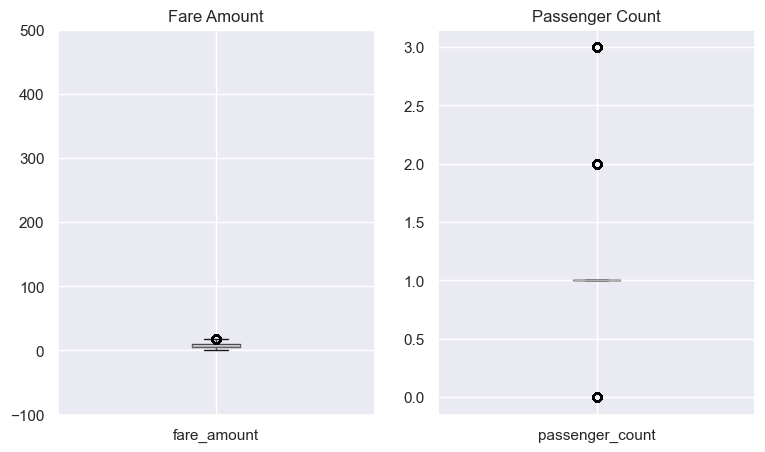

In [73]:
fig, ax = plt.subplots(1,2)

df_clean_iqr.boxplot(column='fare_amount', ax=ax[0])
ax[0].set_title('Fare Amount')
ax[0].set_ylim(-100, 500)

df_clean_iqr.boxplot(column='passenger_count', ax=ax[1])
ax[1].set_title('Passenger Count')

plt.show()

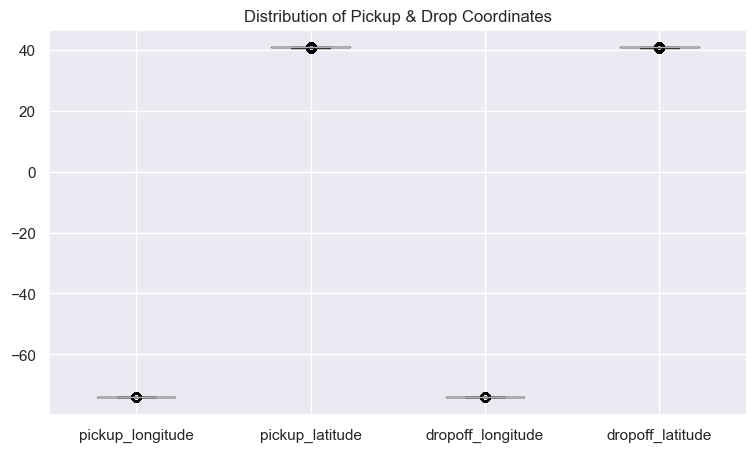

In [74]:
plt.rcParams['figure.figsize'] = (9,5)

ax= df_clean_iqr[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']].boxplot()
ax.set_title('Distribution of Pickup & Drop Coordinates')

plt.show()

In [75]:
# Haversine distance 
from math import cos, asin, sqrt, pi

def distance(lat1, lon1, lat2, lon2):
    r = 6371
    p = pi / 180

    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
    return 2 * r * asin(sqrt(a))

df_clean_iqr["Haversine_distance"] = df_clean_iqr.apply(lambda row: distance(row['pickup_latitude'],row['pickup_longitude'],row['dropoff_latitude'],row['dropoff_longitude']), axis=1)


In [76]:
len(df_clean_iqr)

402309

In [77]:
print(df_clean_iqr['Haversine_distance'].median(),
df_clean_iqr['Haversine_distance'].mean(),
df_clean_iqr['Haversine_distance'].mode())

1.8846484600531868 2.2656236458891077 0    0.0
Name: Haversine_distance, dtype: float64


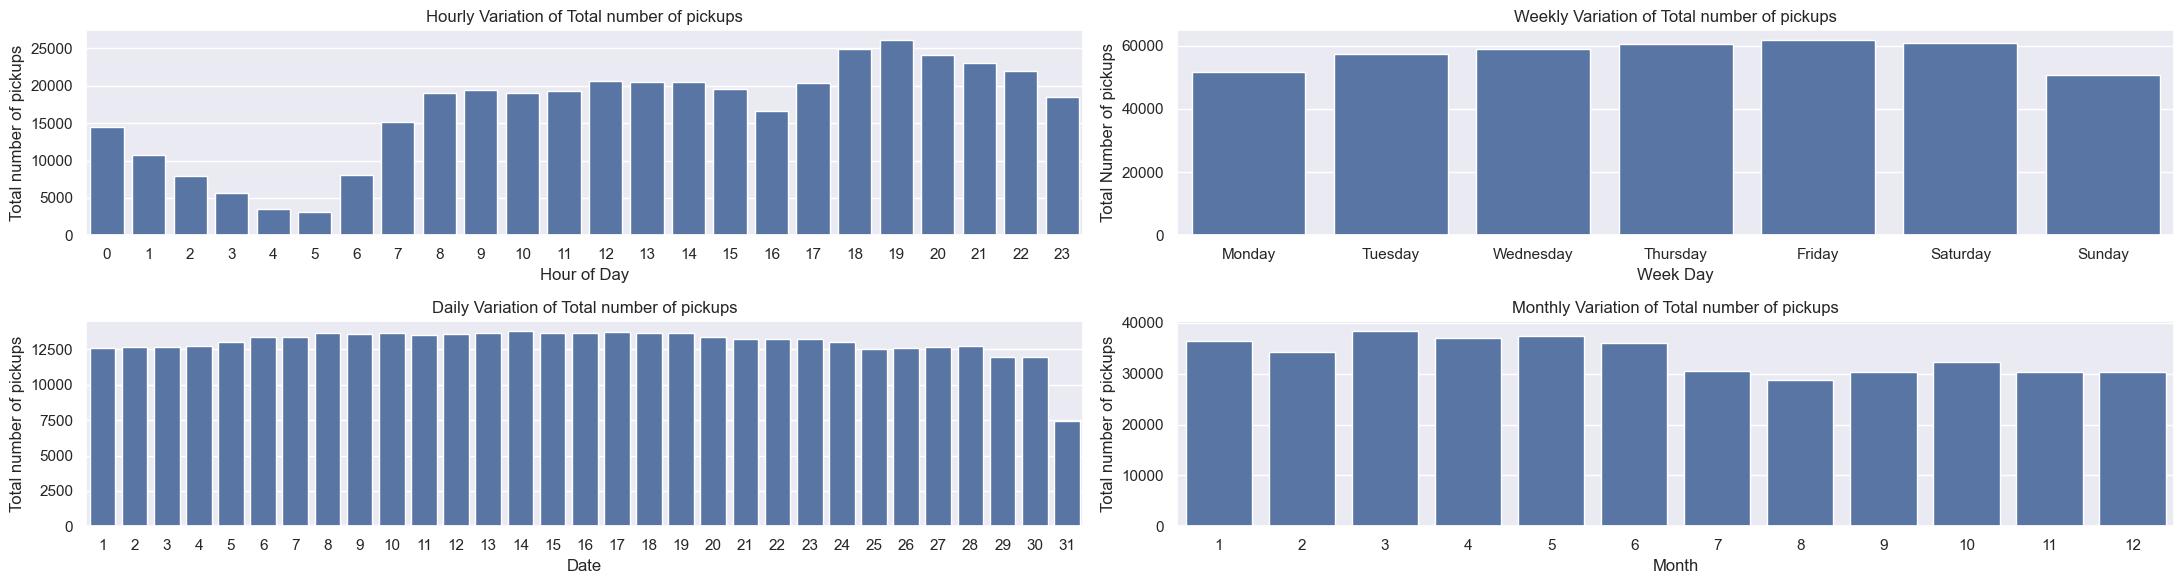

In [78]:
# Ensure that the 'pickup_weekday' column is of type 'category'
df_clean_iqr['pickup_weekday'] = pd.Categorical(df_clean_iqr['pickup_weekday'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)

plt.figure(figsize=(22, 6))

# Hour of day
plt.subplot(221)
sns.countplot(x='pickup_hour', data=df_clean_iqr)
plt.xlabel('Hour of Day')
plt.ylabel('Total number of pickups')
plt.title('Hourly Variation of Total number of pickups')

# Date
plt.subplot(223)
sns.countplot(x='pickup_date', data=df_clean_iqr)
plt.xlabel('Date')
plt.ylabel('Total number of pickups')
plt.title('Daily Variation of Total number of pickups')

# Day of week
plt.subplot(222)
sns.countplot(x='pickup_weekday', data=df_clean_iqr, order=['Monday', 'Tuesday', 'Wednesday', 
                                                        'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xlabel('Week Day')
plt.ylabel('Total Number of pickups')
plt.title('Weekly Variation of Total number of pickups')

# Month
plt.subplot(224)
sns.countplot(x='pickup_month', data=df_clean_iqr)
plt.xlabel('Month')
plt.ylabel('Total number of pickups')
plt.title('Monthly Variation of Total number of pickups')

plt.tight_layout()
plt.show()

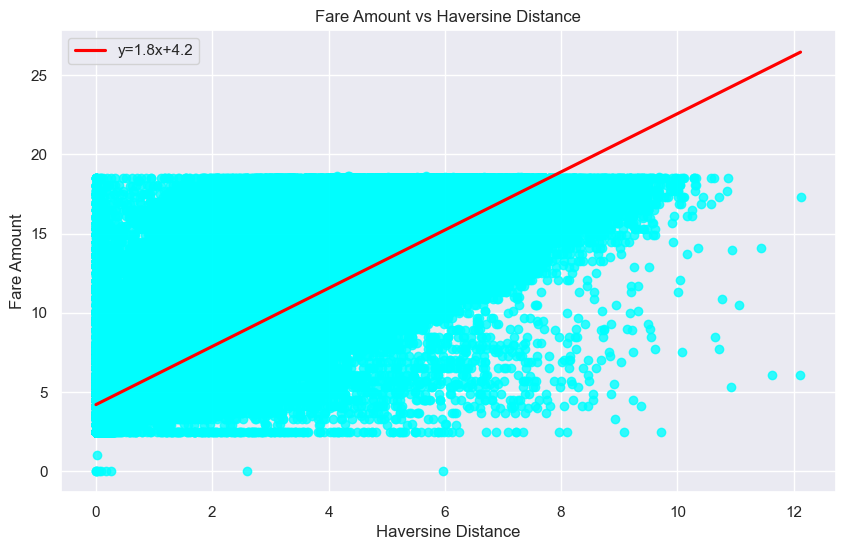

In [79]:
from scipy import stats

x = df_clean_iqr['Haversine_distance']
y = df_clean_iqr['fare_amount']
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

plt.figure(figsize=(10, 6))
ax = sns.regplot(x=x, y=y, 
                 line_kws={'label': f"y={slope:.1f}x+{intercept:.1f}", 'color': "red"},
                 scatter_kws={"color": "cyan"})

plt.xlabel('Haversine Distance')
plt.ylabel('Fare Amount')
plt.title('Fare Amount vs Haversine Distance')

ax.legend()
plt.show()

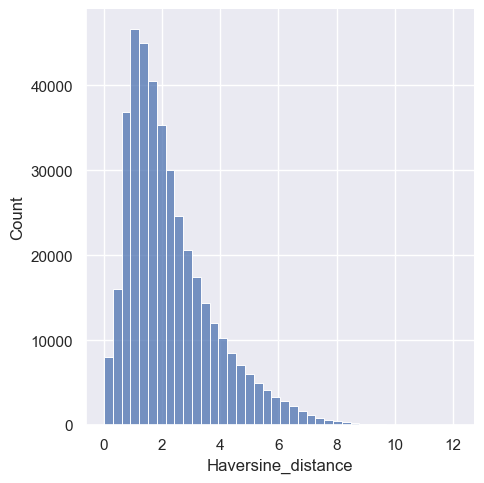

In [80]:
sns.displot(data=df_clean_iqr["Haversine_distance"], bins=40)

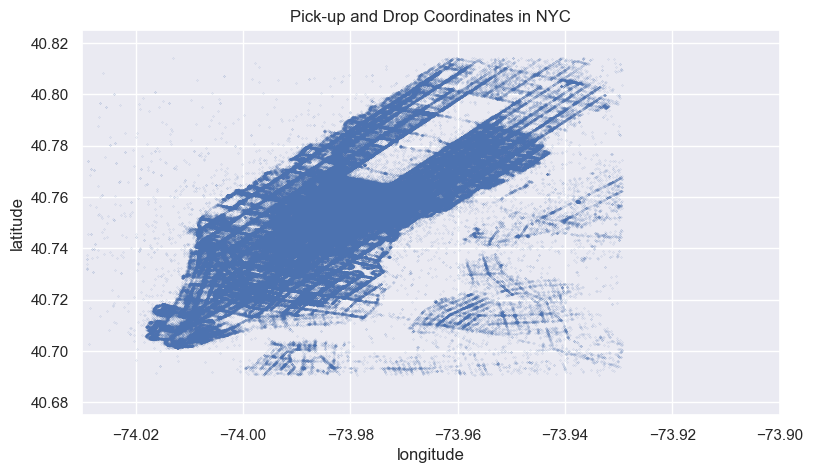

In [81]:
lon_list = list(df_clean_iqr['pickup_longitude']) + list(df_clean_iqr['dropoff_longitude'])
lat_list = list(df_clean_iqr['pickup_latitude']) + list(df_clean_iqr['dropoff_latitude'])
lon_lat_data = {'longitude':lon_list, 'latitude':lat_list}
lon_lat_df = pd.DataFrame(lon_lat_data)

ny_lat_border = [40.675, 40.825]
ny_lon_border = [-74.03, -73.90]

plt.rcParams['figure.figsize'] = (9,5)

lon_lat_df.plot(kind='scatter', x = 'longitude', y = 'latitude', alpha=0.6, s=0.02)
plt.title('Pick-up and Drop Coordinates in NYC')
plt.ylim(ny_lat_border)
plt.xlim(ny_lon_border)

plt.show()

C:\Users\vishn\AppData\Local\Temp\ipykernel_3896\2477962067.py:10: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'nybb' data from the geodatasets package.

from geodatasets import get_path
path_to_file = get_path('nybb')

  nyc = gpd.read_file(gpd.datasets.get_path('nybb'))


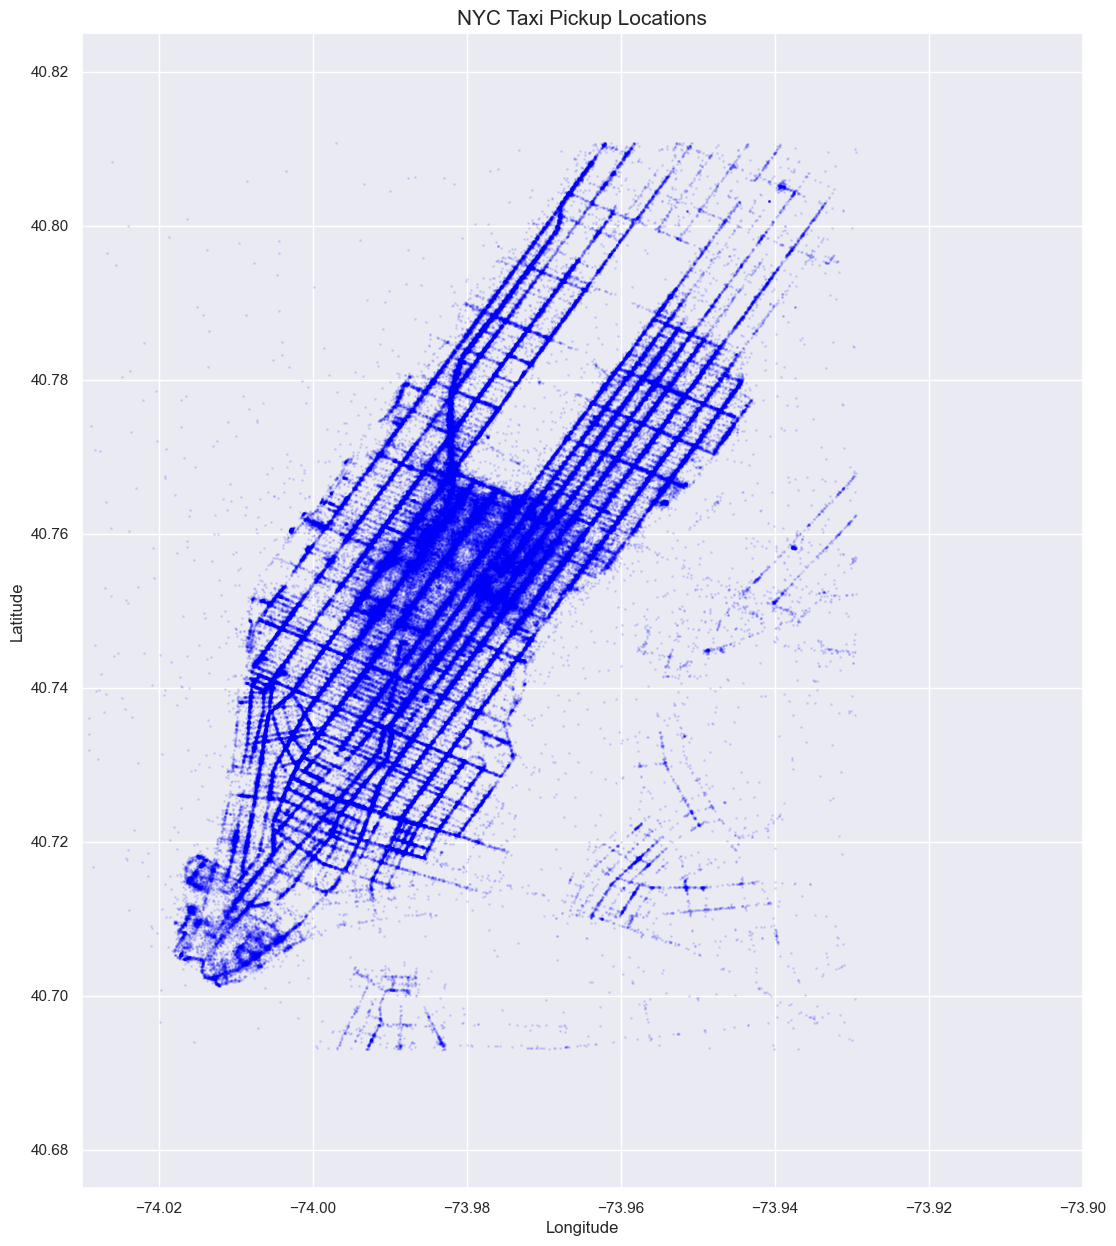

In [82]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Convert your dataframe to a GeoDataFrame
geometry = [Point(xy) for xy in zip(df_clean_iqr['pickup_longitude'], df_clean_iqr['pickup_latitude'])]
gdf = gpd.GeoDataFrame(df_clean_iqr, geometry=geometry)

# Load NYC borough boundaries
nyc = gpd.read_file(gpd.datasets.get_path('nybb'))

# Create the plot
fig, ax = plt.subplots(figsize=(15, 15))

# Plot NYC boroughs
nyc.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plot pickup points
gdf.plot(ax=ax, color='blue', alpha=0.1, markersize=1)

# Set the extent of the map
ax.set_xlim(-74.03, -73.90)
ax.set_ylim(40.675, 40.825)

# Add title and labels
plt.title('NYC Taxi Pickup Locations', fontsize=15)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

# Optional: Save the plot
# plt.savefig('nyc_taxi_pickups.png', dpi=300, bbox_inches='tight')

C:\Users\vishn\AppData\Local\Temp\ipykernel_3896\1182254152.py:18: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'nybb' data from the geodatasets package.

from geodatasets import get_path
path_to_file = get_path('nybb')

  nyc = gpd.read_file(gpd.datasets.get_path('nybb'))


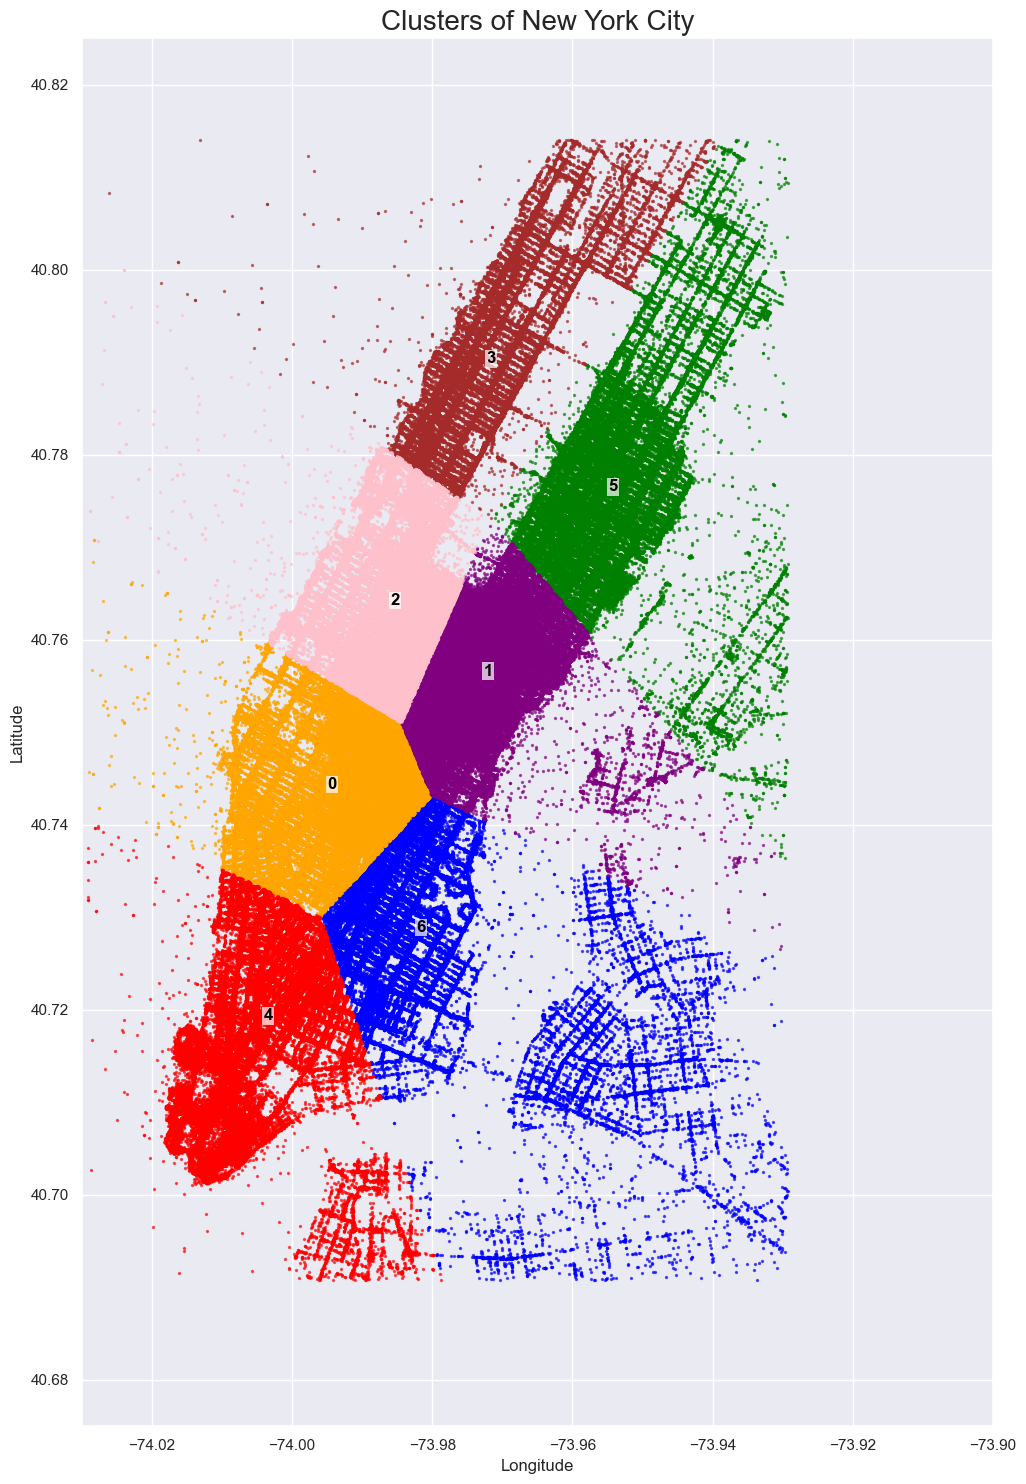

In [83]:
from shapely.geometry import Point
from sklearn.cluster import KMeans
import numpy as np

# Assuming lon_lat_df is your dataframe with longitude and latitude
# Perform K-Means clustering
nyc_clusters = KMeans(n_clusters=7, random_state=42, n_init=10).fit(lon_lat_df[['longitude', 'latitude']])
lon_lat_df['cluster'] = nyc_clusters.labels_

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    lon_lat_df, 
    geometry=[Point(xy) for xy in zip(lon_lat_df.longitude, lon_lat_df.latitude)],
    crs="EPSG:4326"
)

# Load NYC borough boundaries
nyc = gpd.read_file(gpd.datasets.get_path('nybb'))

# Create the plot
fig, ax = plt.subplots(figsize=(15, 15))

# Plot NYC boroughs
nyc.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plot clustered points
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta', 'yellow', 'teal', 'lavender', 'maroon']
for cluster, color in zip(gdf.cluster.unique(), colors):
    cluster_data = gdf[gdf['cluster'] == cluster]
    cluster_data.plot(ax=ax, color=color, alpha=0.6, markersize=2)
    
    # Calculate and plot centroid
    centroid_x = cluster_data.geometry.x.mean()
    centroid_y = cluster_data.geometry.y.mean()
    ax.annotate(f'{cluster}', (centroid_x, centroid_y), fontsize=12, fontweight='bold', color='black', 
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=1))

# Set the extent of the map
ax.set_xlim(ny_lon_border)
ax.set_ylim(ny_lat_border)

# Add title and labels
plt.title('Clusters of New York City', fontsize=20)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

# Optional: Save the plot
# plt.savefig('nyc_taxi_clusters.png', dpi=300, bbox_inches='tight')

In [84]:
# import osmnx as ox
# import networkx as nx
# 
# city = [
#     {
#         "city": "New York",
#         "state": "New York",
#         "country": "USA",
#     }
# ]
# NY_graph = ox.graph_from_place(city, network_type='drive')
# NY_graph2 = ox.graph_from_place('New York, USA', network_type='drive_service')
# ox.save_graphml(NY_graph, 'NY1.graphml')
# ox.save_graphml(NY_graph2, 'NY2.graphml')

In [85]:
# import os
# 
# # print(os.path.isfile("./NY1.graphml") and  os.path.isfile("./NY2.graphml"))
# 
# if not (os.path.isfile("./NY1.graphml") and os.path.isfile("./NY2.graphml")):
#     city = [
#         {
#             "city": "New York",
#             "state": "New York",
#             "country": "USA",
#         }
#     ]
#     NY_graph = ox.graph_from_place(city, network_type='drive')
#     ox.save_graphml(NY_graph, 'NY1.graphml')
# 
#     NY_graph2 = ox.graph_from_place('New York, USA', network_type='drive_service')
#     ox.save_graphml(NY_graph2, 'NY2.graphml')
# 
#     print("Graphs GENERATED successfully")
# else:
#     NY_graph = ox.load_graphml('NY1.graphml')
#     NY_graph2 = ox.load_graphml('NY2.graphml')
#     print("Graphs LOADED successfully")

In [86]:
# start_graph_node = ox.nearest_nodes(NY_graph,-73.982155,40.767937 ,return_dist=True)
# end_graph_node = ox.nearest_nodes(NY_graph,-73.982155,40.765602,return_dist=True)
# 
# # Syntax: nearest_nodes(graph_obj, longitude value, latitude value, if we want the distance or not)

In [87]:
# # THIS METHOD IS IRRELEVANT TAKES TOO MUCH TIME
# from functools import lru_cache
# 
# noPathCounter = 0
# @lru_cache(maxsize=10000)
# def get_road_dist(graph_obj, long1, lat1, long2, lat2):
#     global noPathCounter
#     start_graph_node,start_node_dist = ox.nearest_nodes(graph_obj,long1,lat1,return_dist=True)
#     end_graph_node,end_node_dist = ox.nearest_nodes(graph_obj,long2,lat2,return_dist=True)
# 
#     # distance = ox.shortest_path(graph_obj,start_graph_node,end_graph_node,weight="length", )
#     try:
#         shortest_distance = nx.shortest_path_length(graph_obj,start_graph_node,end_graph_node)
#         # print("shortest path found for node:",start_graph_node,end_graph_node)
#         return shortest_distance +start_node_dist + end_node_dist
#     except nx.NetworkXNoPath as noPathError:
#         shortest_distance = None
#         noPathCounter +=1
#         print(noPathError)
#         return shortest_distance
# 
# df_train["osmnx_distance"] = df_train.apply(lambda row: get_road_dist(NY_graph,row["pickup_longitude"],row["pickup_latitude"],row["dropoff_longitude"],row["dropoff_latitude"]), axis=1)
# df_train.head()

In [88]:
# import requests
# 
# def get_road_dist(row):
#     start_lon, start_lat = row["pickup_longitude"], row["pickup_latitude"]
#     end_lon, end_lat = row["dropoff_longitude"], row["dropoff_latitude"]
# 
#     url = "http://router.project-osrm.org/route/v1/driving/"
#     coords = f"{start_lon},{start_lat};{end_lon},{end_lat}"
#     params = {
#         "geometries": "polyline",
#         "overview": "full",
#         "steps": "true"
#     }
# 
#     try:
#         response = requests.get(url + coords, params=params)
#         response.raise_for_status()
#         data = response.json()
# 
#         if data["code"] == "Ok" and data["routes"]:
#             return data["routes"][0]["distance"]
#         else:
#             print(f"Error: {data['message']}")
#             return None
#     except requests.exceptions.RequestException as e:
#         print(f"Error: {e}")
#         return None
# 
# 
# df_train["osrm_dist"] = df_train.apply(get_road_dist, axis=1)

In [89]:
# import requests
# from itertools import islice
# from functools import lru_cache
# 
# BATCH_SIZE = 200 
# CACHE_SIZE = 10000 
# 
# @lru_cache(maxsize=CACHE_SIZE)
# def get_road_dist_cached(start_lon, start_lat, end_lon, end_lat):
#     url = "http://router.project-osrm.org/route/v1/driving/"
#     coords = f"{start_lon},{start_lat};{end_lon},{end_lat}"
#     params = {
#         "geometries": "polyline",
#         "overview": "full",
#         "steps": "true"
#     }
# 
#     try:
#         response = requests.get(url + coords, params=params)
#         response.raise_for_status()
#         data = response.json()
# 
#         if data["code"] == "Ok" and data["routes"]:
#             return data["routes"][0]["distance"]
#         else:
#             print(f"Error: {data['message']}")
#             return None
#     except requests.exceptions.RequestException as e:
#         print(f"Error: {e}")
#         return None
# 
# def batch(iterable, batch_size):
#     iterator = iter(iterable)
#     while True:
#         batch = list(islice(iterator, batch_size))
#         if not batch:
#             break
#         yield batch
# 
# def get_road_dist_batch(coords):
#     distances = []
#     for start_lon, start_lat, end_lon, end_lat in coords:
#         distance = get_road_dist_cached(start_lon, start_lat, end_lon, end_lat)
#         distances.append(distance)
# 
#     return distances
# 
# coords = list(df_train[["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]].itertuples(index=False, name=None))
# df_train["osrm_dist"] = get_road_dist_batch(coords)

In [90]:
# import requests
# from itertools import islice
# from functools import lru_cache
# import time
# 
# BATCH_SIZE = 100  
# CACHE_SIZE = 10000
# SLEEP_TIME = 1  # Sleep time between batches to avoid rate limiting
# 
# @lru_cache(maxsize=CACHE_SIZE)
# def get_road_dist_cached(start_lon, start_lat, end_lon, end_lat):
#     url = "http://router.project-osrm.org/route/v1/driving/"
#     coords = f"{start_lon},{start_lat};{end_lon},{end_lat}"
#     params = {
#         "geometries": "polyline",
#         "overview": "full",
#         "steps": "true"
#     }
# 
#     try:
#         response = requests.get(url + coords, params=params)
#         response.raise_for_status()
#         data = response.json()
# 
#         if data["code"] == "Ok" and data["routes"]:
#             distance = data["routes"][0]["distance"]
#         else:
#             print(f"Error: {data['message']}")
#             distance = None
# 
#         return distance
#     except requests.exceptions.RequestException as e:
#         print(f"Error: {e}")
#         return None
# 
# def batch(iterable, batch_size):
#     iterator = iter(iterable)
#     while True:
#         batch = list(islice(iterator, batch_size))
#         if not batch:
#             break
#         yield batch
# 
# def get_road_dist_batch(coords):
#     distances = []
#     total_batches = len(coords) // BATCH_SIZE
#     start_time = time.time()
#     for i, coord_batch in enumerate(batch(coords, BATCH_SIZE), 1):
#         batch_start_time = time.time()
#         for start_lon, start_lat, end_lon, end_lat in coord_batch:
#             distance = get_road_dist_cached(start_lon, start_lat, end_lon, end_lat)
#             distances.append(distance)
#         batch_time = time.time() - batch_start_time
#         print(f"Batch {i}/{total_batches} time: {batch_time:.2f} seconds")
#         time.sleep(SLEEP_TIME)  # Sleep to avoid hitting rate limits
#     total_time = time.time() - start_time
#     print(f"Total time for {total_batches} batches: {total_time:.2f} seconds")
#     return distances
# 
# coords = list(df_train[["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]].itertuples(index=False, name=None))
# df_train["osrm_dist"] = get_road_dist_batch(coords)

In [91]:
# import requests
# import pandas as pd
# from concurrent.futures import ThreadPoolExecutor, as_completed
# import time
# import hashlib
# 
# # Initialize a cache
# cache = {}
# 
# def get_road_dist(start_lon, start_lat, end_lon, end_lat):
#     # Create a unique key for the route using hashing for efficiency
#     route_key = hashlib.md5(f"{start_lon},{start_lat},{end_lon},{end_lat}".encode()).hexdigest()
# 
#     # Check if the distance is already in the cache
#     if route_key in cache:
#         return cache[route_key]
# 
#     url = "http://router.project-osrm.org/route/v1/driving/"
#     coords = f"{start_lon},{start_lat};{end_lon},{end_lat}"
#     params = {
#         "geometries": "polyline",
#         "overview": "full",
#         "steps": "true"
#     }
# 
#     try:
#         response = requests.get(url + coords, params=params)
#         response.raise_for_status()
#         data = response.json()
# 
#         if data["code"] == "Ok" and data["routes"]:
#             distance = data["routes"][0]["distance"]
#             # Save the distance in the cache
#             cache[route_key] = distance
#             return distance
#         else:
#             print(f"Error: {data['message']}")
#             return None
#     except requests.exceptions.RequestException as e:
#         print(f"Error: {e}")
#         return None
# 
# def process_row(row):
#     start_time_row = time.time()
#     distance_osrm = get_road_dist(row["pickup_longitude"], row["pickup_latitude"], row["dropoff_longitude"], row["dropoff_latitude"])
#     end_time_row = time.time()
#     print("current row processing time: ", end_time_row - start_time_row)
#     return  distance_osrm
# 
# # Function to handle parallel processing
# def parallel_process(df, func, n_jobs=50):
#     results = []
#     with ThreadPoolExecutor(max_workers=n_jobs) as executor:
#         futures = [executor.submit(func, row) for _, row in df.iterrows()]
#         for future in as_completed(futures):
#             results.append(future.result())
#     return results
# 
# 
# # Apply the function to the dataframe with parallel processing
# start_time = time.time()
# df_train["osrm_dist"] = parallel_process(df_train, process_row, n_jobs=8)
# end_time = time.time()
# 
# print(df_train)
# print(f"Processing time: {end_time - start_time} seconds")

In [92]:
# import aiohttp
# import asyncio
# import hashlib
# import time
# 
# # Initialize a cache
# cache = {}
# 
# async def get_road_dist(session, start_lon, start_lat, end_lon, end_lat):
#     # Create a unique key for the route using hashing for efficiency
#     route_key = hashlib.md5(f"{start_lon},{start_lat},{end_lon},{end_lat}".encode()).hexdigest()
# 
#     # Check if the distance is already in the cache
#     if route_key in cache:
#         return cache[route_key]
# 
#     url = f"http://router.project-osrm.org/route/v1/driving/{start_lon},{start_lat};{end_lon},{end_lat}"
#     params = {
#         "geometries": "polyline",
#         "overview": "full",
#         "steps": "true"
#     }
# 
#     try:
#         async with session.get(url, params=params) as response:
#             data = await response.json()
#             if data["code"] == "Ok" and data["routes"]:
#                 distance = data["routes"][0]["distance"]
#                 # Save the distance in the cache
#                 cache[route_key] = distance
#                 return distance
#             else:
#                 print(f"Error: {data['message']}")
#                 return None
#     except aiohttp.ClientError as e:
#         print(f"Error: {e}")
#         return None
# 
# async def process_row(session, row):
#     start_time_row = time.time()
#     distance_osrm = await get_road_dist(session, row["pickup_longitude"], row["pickup_latitude"], row["dropoff_longitude"], row["dropoff_latitude"])
#     end_time_row = time.time()
#     print("Current row processing time: ", end_time_row - start_time_row)
#     return distance_osrm
# 
# async def main(df):
#     async with aiohttp.ClientSession() as session:
#         tasks = []
#         for _, row in df.iterrows():
#             tasks.append(process_row(session, row))
#         results = await asyncio.gather(*tasks)
#         return results
# 
# # Apply the function to the dataframe with asynchronous processing
# start_time = time.time()
# df_train["osrm_dist"] = await main(df_train)
# end_time = time.time()
# 
# print(df_train)
# print(f"Total processing time: {end_time - start_time} seconds")

In [93]:
dataset_features = ['Haversine_distance','pickup_longitude','pickup_latitude','dropoff_latitude','dropoff_longitude','passenger_count','pickup_date','pickup_month']

X = df_clean_iqr[dataset_features]
y = df_clean_iqr['fare_amount']

In [94]:
from sklearn.tree import DecisionTreeRegressor

taxi_model = DecisionTreeRegressor(random_state=1)

taxi_model.fit(X,y)

DecisionTreeRegressor(random_state=1)

In [95]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
taxi_model = DecisionTreeRegressor()
taxi_model.fit(X_train,y_train)

fare_predictions = taxi_model.predict(X_test)
print("MAE= ",mean_absolute_error(y_test, fare_predictions))
print("MSE= ",mean_squared_error(y_test, fare_predictions))

MAE=  1.9205898413446338
MSE=  7.338643539372947


In [96]:
def get_mae(max_leaf_nodes, train_X, train_y, test_X, test_y):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=1)
    model.fit(train_X, train_y)
    predictions = model.predict(test_X)
    mae = mean_absolute_error(test_y, predictions)
    return mae

def get_mse(max_leaf_nodes, train_X, train_y, test_X, test_y):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=1)
    model.fit(train_X,train_y)
    predictions = model.predict(test_X)
    mse = mean_squared_error(test_y,predictions)
    return mse

def driver_function():
    for max_leaf_nodes in [5,10,50,100,500,1000,5000,10000]:
        mae = get_mae(max_leaf_nodes,X_train,y_train, X_test,y_test)
        mse = get_mse(max_leaf_nodes,X_train,y_train, X_test,y_test)
        print(f"Max Leaf Nodes: {max_leaf_nodes}\t MAE: {mae}\t MSE: {mse}")

driver_function()

Max Leaf Nodes: 5	 MAE: 1.6257436588171672	 MSE: 4.698156459452845
Max Leaf Nodes: 10	 MAE: 1.5331640242097646	 MSE: 4.325965420392779
Max Leaf Nodes: 50	 MAE: 1.4839768540562752	 MSE: 4.112022809150668
Max Leaf Nodes: 100	 MAE: 1.4740473707738173	 MSE: 4.06676854343822
Max Leaf Nodes: 500	 MAE: 1.442906991025926	 MSE: 3.940482403867943
Max Leaf Nodes: 1000	 MAE: 1.4354775422918313	 MSE: 3.9472058290115535
Max Leaf Nodes: 5000	 MAE: 1.461501550542764	 MSE: 4.336903092767651
Max Leaf Nodes: 10000	 MAE: 1.5138330595289937	 MSE: 4.819400248973428


The best iteration is with max leaf nodes = 1000

In [98]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error

model = DecisionTreeRegressor(max_leaf_nodes=1000, random_state=1)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
rmse = root_mean_squared_error(y_test,predictions)

print(f"MAE for RandomForest: {mae}\nRMSE for RandomForest: {rmse}")

MAE for RandomForest: 1.4354775422918313
 RMSE for RandomForest: 1.9867576170765153


In [50]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error

forest_model = RandomForestRegressor(random_state=1)
forest_model.fit(X_train,y_train)
randomforest_predictions = forest_model.predict(X_test)
print("MAE for RandomForest: ", mean_absolute_error(y_test,randomforest_predictions))
print("MSE for Randomforest: ", mean_squared_error(y_test,randomforest_predictions))

MAE for RandomForest:  1.37165101072303
MSE for Randomforest:  3.6306501113395564


In [53]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error

print("RMSE for Randomforest: ", root_mean_squared_error(y_test,randomforest_predictions))

RMSE for Randomforest:  1.905426490668049


In [58]:
df_test = pd.read_csv("./test.csv")
# df_test.head()
df_test['pickup_datetime'] = pd.to_datetime(df_test['pickup_datetime'])
df_test.loc[:, 'pickup_date'] = df_test['pickup_datetime'].dt.day
df_test.loc[:, 'pickup_month'] = df_test['pickup_datetime'].dt.month
df_test.loc[:, 'pickup_year'] = df_test['pickup_datetime'].dt.year

In [59]:
# df_test.describe()
# df_test.head()
df_test["Haversine_distance"] = df_test.apply(lambda row: distance(row['pickup_latitude'],row['pickup_longitude'],row['dropoff_latitude'],row['dropoff_longitude']), axis=1)

In [60]:
y_test = df_test[dataset_features]
test_preds = forest_model.predict(y_test)
test_preds

array([ 7.86899996,  8.76500001,  4.552     , ..., 11.39799991,
       15.77599997,  6.48500001])

In [61]:
df_preds = pd.DataFrame(test_preds, columns=['fare_amount'])
df_preds['key'] = df_test['key']
print(df_preds)
df_preds.to_csv('./test_predictions.csv',index=False)

      fare_amount                          key
0           7.869  2015-01-27 13:08:24.0000002
1           8.765  2015-01-27 13:08:24.0000003
2           4.552  2011-10-08 11:53:44.0000002
3           8.891  2012-12-01 21:12:12.0000002
4          14.655  2012-12-01 21:12:12.0000003
...           ...                          ...
9909        8.585  2015-05-10 12:37:51.0000002
9910        9.678  2015-01-12 17:05:51.0000001
9911       11.398  2015-04-19 20:44:15.0000001
9912       15.776  2015-01-31 01:05:19.0000005
9913        6.485  2015-01-18 14:06:23.0000006

[9914 rows x 2 columns]


In [62]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

forest_model_CV = RandomForestRegressor(random_state=1)
grid_search = GridSearchCV(estimator=forest_model_CV,
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_absolute_error',
                           n_jobs=-1,
                           verbose=2)

grid_search.fit(X_train,y_train)
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", -grid_search.best_score_)

best_model = grid_search.best_estimator_
randomforest_predictions_CV = best_model.predict(X_train)
print("MAE for best Random Forest: ", mean_absolute_error(y_test, randomforest_predictions))
print("MSE for best Random Forest: ", mean_squared_error(y_test, randomforest_predictions))

Fitting 5 folds for each of 162 candidates, totalling 810 fits


KeyboardInterrupt: 

In [61]:
forest_model_IQR = RandomForestRegressor(max_depth=None, max_features='sqrt', min_samples_leaf=4,min_samples_split=2,n_estimators=300)
forest_model_IQR.fit(X_train,y_train)
randomforest_predictions_IQR = forest_model_IQR.predict(X_train)
print("MAE for RandomForest IQR: ", mean_absolute_error(y_test,randomforest_predictions_IQR))
print("MSE for Randomforest IQR: ", mean_squared_error(y_test,randomforest_predictions_IQR))

In [62]:
from xgboost import XGBRegressor

xg_model = XGBRegressor(n_estimators=500, learning_rate=0.05, n_jobs=-1)
xg_model.fit(X_train, y_train,
             early_stopping_rounds=5, 
             eval_set=[(X_train, y_test)],
             verbose=False)
xg_predictions = xg_model.predict(X_train)
print("MAE: ",mean_absolute_error(y_test,xg_predictions))
print("MSE: ",mean_squared_error(y_test,xg_predictions))

C:\Users\vishn\anaconda3\envs\oxVer2\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


MAE:  1.5459923935449371
MSE:  7.371399641994236


In [63]:
from sklearn.model_selection import cross_val_score

r_squared = np.mean(cross_val_score(forest_model_IQR,X_train,y_train,cv=5))
standard_deviation = np.std(cross_val_score(forest_model_IQR,X_train,y_train,cv=5))
print("r squared = ",r_squared)
print("standard deviation = ", standard_deviation)

r squared =  0.5404186307370128
standard deviation =  0.019729518767674696


In [60]:
# Voting Regressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor

rf_model = RandomForestRegressor(random_state=1)
xgb_model = XGBRegressor(random_state=1)
lr_model = LinearRegression()

ensemble_model = VotingRegressor([
    ('rf', rf_model),
    ('xgb', xgb_model),
    ('lr', lr_model)
])

ensemble_model.fit(X_train, y_train)
ensemble_predictions = ensemble_model.predict(X_train)

print("MAE for Ensemble: ", mean_absolute_error(y_test, ensemble_predictions))
print("MSE for Ensemble: ", mean_squared_error(y_test, ensemble_predictions))


MAE for Ensemble:  1.539112537241742
MSE for Ensemble:  7.263176981478515


In [67]:
from sklearn.ensemble import VotingRegressor

rf_model1 = RandomForestRegressor(random_state=1)
rf_model2 = RandomForestRegressor(random_state=42)
rf_model3 = RandomForestRegressor(random_state=99)

ensemble_modelv2 = VotingRegressor([
    ('rf1', rf_model1),
    ('rf2', rf_model2),
    ('rf3', rf_model3),
])

ensemble_modelv2.fit(X_train, y_train)
ensemblev2_predictions = ensemble_modelv2.predict(X_train)

print("MAE for Ensemble: ", mean_absolute_error(y_test, ensemblev2_predictions))
print("MSE for Ensemble: ", mean_squared_error(y_test, ensemblev2_predictions))

MAE for Ensemble:  1.604164734703633
MSE for Ensemble:  7.934481718123672


In [61]:
from sklearn.ensemble import StackingRegressor

stacking_model = StackingRegressor([
    ('rf', rf_model),
    ('xgb', xgb_model),
    ('lr', lr_model)
], final_estimator=LinearRegression())

stacking_model.fit(X_train, y_train)
stacking_predictions = stacking_model.predict(X_train)

print("MAE for Stacking: ", mean_absolute_error(y_test, stacking_predictions))
print("MSE for Stacking: ", mean_squared_error(y_test, stacking_predictions))

MAE for Stacking:  1.5268678000529117
MSE for Stacking:  7.2819369937442335


In [68]:
from sklearn.ensemble import StackingRegressor

stacking_model = StackingRegressor([
    ('rf1', rf_model1),
    ('rf2', rf_model2),
    ('rf3', rf_model3),
], final_estimator=RandomForestRegressor())

stacking_model.fit(X_train, y_train)
stacking_predictions = stacking_model.predict(X_train)

print("MAE for Stacking: ", mean_absolute_error(y_test, stacking_predictions))
print("MSE for Stacking: ", mean_squared_error(y_test, stacking_predictions))

MAE for Stacking:  1.7523206142447418
MSE for Stacking:  10.234078233318593


In [101]:
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import accuracy_score

rf_bagging = RandomForestRegressor(random_state=1)

bag = BaggingRegressor(estimator=rf_bagging, n_estimators=10)

bag.fit(X_train, y_train)
bag_pred = bag.predict(X_train)


print("MAE for Bagging: ", mean_absolute_error(y_test, bag_pred))
print("MSE for Bagging: ", mean_squared_error(y_test, bag_pred))
print("RMSE for Bagging: ", root_mean_squared_error(y_test, bag_pred))
# acc = accuracy_score(y_test, bag_pred)
# acc = acc*100
# print(f"Accuracy: {acc:.2f} %")

KeyboardInterrupt: 

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

rf_boosting = DecisionTreeRegressor(max_leaf_nodes=1000,random_state=1)

boost = AdaBoostRegressor(estimator=rf_boosting, n_estimators=10)

boost.fit(X_train, y_train)
boost_pred = boost.predict(X_train)

print("MAE for Boosting: ", mean_absolute_error(y_test, boost_pred))
print("MSE for Boosting: ", mean_squared_error(y_test, boost_pred))
print("RMSE for Boosting: ", root_mean_squared_error(y_test, boost_pred))

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

# Split the training data to create a hold-out set
X_train, X_holdout, y_train, y_holdout = train_test_split(X_train, y_train, test_size=0.3, random_state=1)

# Create and train base models
rf_model = RandomForestRegressor(random_state=1)
xgb_model = XGBRegressor(random_state=1)
lr_model = LinearRegression()

rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
lr_model.fit(X_train, y_train)

# Make predictions on the hold-out set
rf_holdout_pred = rf_model.predict(X_holdout)
xgb_holdout_pred = xgb_model.predict(X_holdout)
lr_holdout_pred = lr_model.predict(X_holdout)

# Create a new dataset for the meta-model
X_meta = np.column_stack((rf_holdout_pred, xgb_holdout_pred, lr_holdout_pred))

# Train the meta-model
meta_model = LinearRegression()
meta_model.fit(X_meta, y_holdout)

# Make predictions on the test set
rf_test_pred = rf_model.predict(X_train)
xgb_test_pred = xgb_model.predict(X_train)
lr_test_pred = lr_model.predict(X_train)
X_meta_test = np.column_stack((rf_test_pred, xgb_test_pred, lr_test_pred))

# Final predictions
blending_predictions = meta_model.predict(X_meta_test)

# Evaluate the model
print("MAE for Blending: ", mean_absolute_error(y_test, blending_predictions))
print("MSE for Blending: ", mean_squared_error(y_test, blending_predictions))

MAE for Blending:  1.5331643505290653
MSE for Blending:  7.310903519471023


In [68]:
def create_time_features(df):
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    
    df['hour'] = df['pickup_datetime'].dt.hour
    
    df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
    
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    df['month'] = df['pickup_datetime'].dt.month
    
    df['season'] = (df['month'] % 12 + 3) // 3
    
    df['is_rush_hour'] = ((df['hour'] >= 7) & (df['hour'] <= 10) | 
                          (df['hour'] >= 16) & (df['hour'] <= 19)).astype(int)
    
    return df

df_clean_iqr = create_time_features(df_clean_iqr)

In [69]:
def create_distance_features(df):
    df['manhattan_distance'] = np.abs(df['dropoff_latitude'] - df['pickup_latitude']) + \
                               np.abs(df['dropoff_longitude'] - df['pickup_longitude'])
    
    df['euclidean_distance'] = np.sqrt(
        (df['dropoff_latitude'] - df['pickup_latitude'])**2 + 
        (df['dropoff_longitude'] - df['pickup_longitude'])**2
    )
    
    df['direction'] = np.arctan2(
        df['dropoff_latitude'] - df['pickup_latitude'],
        df['dropoff_longitude'] - df['pickup_longitude']
    )
    
    times_square_lat, times_square_lon = 40.7580, -73.9855
    df['pickup_distance_from_center'] = np.sqrt(
        (df['pickup_latitude'] - times_square_lat)**2 + 
        (df['pickup_longitude'] - times_square_lon)**2
    )
    df['dropoff_distance_from_center'] = np.sqrt(
        (df['dropoff_latitude'] - times_square_lat)**2 + 
        (df['dropoff_longitude'] - times_square_lon)**2
    )
    return df

df_clean_iqr = create_distance_features(df_clean_iqr)

In [71]:
from sklearn.cluster import KMeans

def create_cluster_features(df, n_clusters=10):
    pickup_coords = df[['pickup_latitude', 'pickup_longitude']].values
    pickup_kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df['pickup_cluster'] = pickup_kmeans.fit_predict(pickup_coords)
    
    dropoff_coords = df[['dropoff_latitude', 'dropoff_longitude']].values
    dropoff_kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df['dropoff_cluster'] = dropoff_kmeans.fit_predict(dropoff_coords)
    
    return df

df_clean_iqr = create_cluster_features(df_clean_iqr)

C:\Users\vishn\anaconda3\envs\oxVer2\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\vishn\anaconda3\envs\oxVer2\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [72]:
df_clean_iqr.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,pickup_month,...,month,season,is_rush_hour,manhattan_distance,euclidean_distance,direction,pickup_distance_from_center,dropoff_distance_from_center,pickup_cluster,dropoff_cluster
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,18,8,...,8,3,0,0.019212,0.013674,-2.241974,0.004280,0.009397,0,3
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,21,4,...,4,2,0,0.029386,0.025340,1.746799,0.024910,0.006068,5,2
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,9,3,...,3,2,1,0.027194,0.019470,0.942725,0.020077,0.038674,3,1
5,2011-01-06 09:50:45.0000002,12.1,2011-01-06 09:50:45+00:00,-74.000964,40.731630,-73.972892,40.758233,1,6,1,...,1,1,1,0.054675,0.038675,0.758537,0.030570,0.012610,2,5
6,2012-11-20 20:35:00.0000001,7.5,2012-11-20 20:35:00+00:00,-73.980002,40.751662,-73.973802,40.764842,1,20,11,...,11,4,0,0.019380,0.014565,1.131100,0.008390,0.013552,7,5


In [75]:
dataset_features = [
    'Haversine_distance', 'pickup_longitude', 'pickup_latitude', 'dropoff_latitude', 'dropoff_longitude',
    'passenger_count', 'pickup_date', 'pickup_month', 'pickup_year',
    'hour', 'day_of_week', 'is_weekend', 'season', 'is_rush_hour',
    'manhattan_distance', 'direction',
    'pickup_distance_from_center', 'dropoff_distance_from_center',
    'pickup_cluster', 'dropoff_cluster'
]

X = df_clean_iqr[dataset_features]
y = df_clean_iqr['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(random_state=1)
rf_model.fit(X_train, y_train)

rf_predictions = rf_model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, rf_predictions))
print("MSE:", mean_squared_error(y_test, rf_predictions))
print("RMSE:", np.sqrt(mean_squared_error(y_test, rf_predictions)))

feature_importance = pd.DataFrame({
    'feature': dataset_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance)

MAE: 1.5510470363288718
MSE: 10.349322450305928
RMSE: 3.2170362836477193
                         feature  importance
0             Haversine_distance    0.554874
15                     direction    0.061428
8                    pickup_year    0.049094
14            manhattan_distance    0.043587
4              dropoff_longitude    0.036004
3               dropoff_latitude    0.030828
17  dropoff_distance_from_center    0.030557
9                           hour    0.029858
1               pickup_longitude    0.027444
6                    pickup_date    0.022908
2                pickup_latitude    0.022640
16   pickup_distance_from_center    0.022060
7                   pickup_month    0.019273
10                   day_of_week    0.013118
19               dropoff_cluster    0.009395
18                pickup_cluster    0.008643
12                        season    0.006598
5                passenger_count    0.006093
13                  is_rush_hour    0.003126
11                    is_we

In [76]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

# Define the model pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBRegressor(objective='reg:squarederror'))
])

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__max_depth': [3, 5, 7],
    'model__min_child_weight': [1, 3, 5]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=KFold(n_splits=5), scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

# Best model and MAE
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)

print(f"Best MAE: {mae}")
print(f"Best Parameters: {grid_search.best_params_}")


Best MAE: 1.387447520834652
Best Parameters: {'model__learning_rate': 0.05, 'model__max_depth': 7, 'model__min_child_weight': 1, 'model__n_estimators': 300}


In [77]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assume df_clean_iqr is your preprocessed dataframe

# 1. Add interaction features
df_clean_iqr['time_day_interaction'] = df_clean_iqr['hour'] * df_clean_iqr['day_of_week']
df_clean_iqr['distance_time_interaction'] = df_clean_iqr['Haversine_distance'] * df_clean_iqr['hour']
df_clean_iqr['passenger_distance_interaction'] = df_clean_iqr['passenger_count'] * df_clean_iqr['Haversine_distance']

# 2. Polynomial features for distance
poly = PolynomialFeatures(degree=2, include_bias=False)
distance_poly = poly.fit_transform(df_clean_iqr[['Haversine_distance']])
df_clean_iqr['distance_squared'] = distance_poly[:, 1]

# 3. Update feature list
features = [
    'Haversine_distance', 'pickup_longitude', 'pickup_latitude', 'dropoff_latitude', 'dropoff_longitude',
    'passenger_count', 'hour', 'day_of_week', 'is_weekend', 'season', 'is_rush_hour',
    'manhattan_distance', 'direction', 'pickup_distance_from_center', 'dropoff_distance_from_center',
    'pickup_cluster', 'dropoff_cluster', 'time_day_interaction', 'distance_time_interaction',
    'passenger_distance_interaction', 'distance_squared'
]

X = df_clean_iqr[features]
y = df_clean_iqr['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. LightGBM model with hyperparameter tuning
param_dist = {
    'num_leaves': [31, 127, 255],
    'max_depth': [-1, 15, 31],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 500, 1000],
    'min_child_samples': [5, 10, 20],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

lgb_model = LGBMRegressor(random_state=42)
random_search = RandomizedSearchCV(lgb_model, param_distributions=param_dist, n_iter=20, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

best_lgb_model = random_search.best_estimator_
lgb_predictions = best_lgb_model.predict(X_test)

print("LightGBM MAE:", mean_absolute_error(y_test, lgb_predictions))
print("LightGBM RMSE:", np.sqrt(mean_squared_error(y_test, lgb_predictions)))

# 5. Feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': best_lgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(10))

AttributeError: module 'pandas' has no attribute 'Int64Index'

In [ ]:
s = "racecar"
t= "carrace"

for i in s:
    